<a href="https://colab.research.google.com/github/patrickmcm25/Hands-on-Machine-Learning/blob/main/Chapter_3_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Chapter 3  - Classification


##MNIST

In [2]:

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [3]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])

In [4]:
# 70,000 images and each image has 784 features. Each image is 28 X 28 pixels

X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

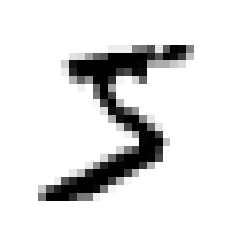

In [6]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap=mpl.cm.binary, 
           interpolation='nearest')
plt.axis('off')
plt.show()

In [7]:
y[0]

'5'

In [8]:
# First 60K is training, next 10K (70K images - 60K training) is test
X_train, X_test =  X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

In [9]:
# Shuffle the training sets

#shuffle_index = np.random.permutation(60000)
#X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

##Training a Binary Classifier

In [10]:
# Let try to identify one digit (5 and not 5)
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [11]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
# This predicted that it will be a 5 which is true based on the above image
sgd_clf.predict([some_digit])

array([ True])

##Performance Measures

Measuring Accuracy Using Cross Validation

In [13]:
# Stratified sampling that creates a clone of the classifier, trains the clone on the training folds, makes predictions on the fold, then counts the number of correct predictions

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = (y_train_5[train_index])
  X_test_fold = X_train[test_index]
  y_test_fold = (y_train_5[test_index])

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [14]:
# Evaluate the SGDClassifier model using K-fold cross validation using 3 folds (cv=3)

from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Confusion Matrix

 - Much better way to evaluate the performance of a classifier

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

- 53,892 classified correctly as non 5s (negative class)
- 687 were wrongly classified as non 5s (false positives)
- 1891 were wrongly classified as 5s (false negatives)
- 3530 were correctly classfied as 5s (true positives)

Precision and Recall

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
cm = confusion_matrix(y_train_5, y_train_pred)
cm[1, 1] / (cm[0, 1] + cm[1, 1])

0.8370879772350012

In [19]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [20]:
# Same thing as recall score - the hard way
cm[1, 1] / (cm[1, 0] + cm[1, 1])

0.6511713705958311

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [23]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [27]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')

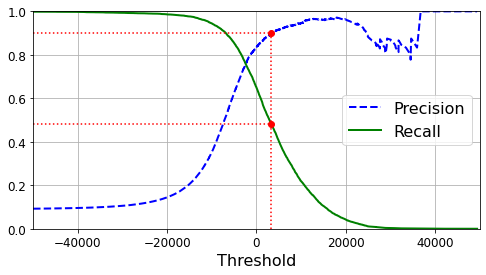

In [32]:
# A way to show how to determine which threshold to use 

from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
  plt.legend(loc='center right', fontsize=16)
  plt.xlabel('Threshold', fontsize=16)
  plt.grid(True)
  plt.axis([-50000, 50000, 0, 1])

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown

plt.show()

Saving figure precision_vs_recall_plot


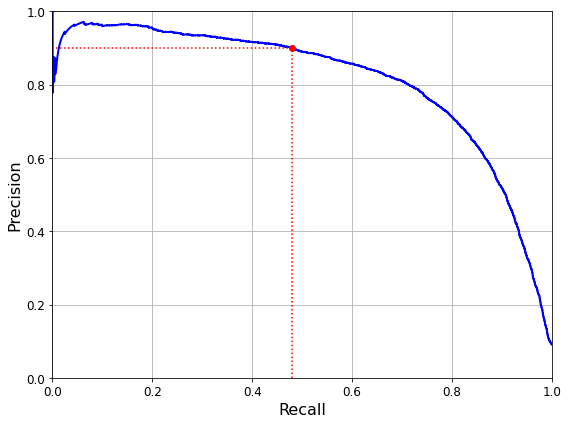

In [33]:
# Plot precision directly against recall

def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
save_fig("precision_vs_recall_plot")

plt.show()

Precision starts to fall sharply around 80% recall